##### **Author(s)**:  Zareef Jafar, Anowar J. Shajib

Acknowledgement: S M Rafee Adnan

In [1]:
import time

import h5py
import joblib
import matplotlib.pyplot as plt

# import of standard python libraries
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
import corner
%matplotlib inline

## Load imaging data

The data and the PSF needs to be provided to `lenstronomy` using the
dictionaries `kwargs_data` and `kwargs_psf`.

In `kwargs_data`, we also need to proivde information on the noise level.
Either the pixel-wise noise map can be provided using the `noise_map`
keyword, or simply the `exposure_time` and `background_rms` can be provided
for `lenstronomy` to create the noise map by itself.

The keywords `ra_at_xy_0` and `dec_at_xy_0` are the RA and Declination in
arcsecond units at the (0, 0) pixel. The keyword `transform_pix2angle` is
the transformation matrix from pixel number coordinates to (RA, Decl.).
These keywords are used to convert pixel coordinates to RA and Decl.
coordinates. If you want to convert one 2D coordinate system to another, you
 will need to the offset between the zeropoints of two coordinate systems
 and transformation matrix that specifies the scaling and rotation of the
 axes. So, the keywords `ra_at_xy_0` and `dec_at_xy_0` specify the zeropoint
  offsets, and `transform_pix2angle` is the tansformation matrix specifying
  scaling and rotation.

For the first example of lensing data, no PSF was used to create the data.
Therefore, `psf_type` is set to `NONE`. For real data, there has to be a PSF
. We will work with PSFs in later examples.

In [2]:
with h5py.File("./DESIJ1554+0443_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]


# load HDF5 psf file using h5py
with h5py.File("./psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf["psf_type"] = "PIXEL"

kwargs_data

{'background_rms': 0.0137866616807371,
 'dec_at_xy_0': -4.839999999999995,
 'exposure_time': array([[526.58203, 420.42545, 478.3544 , ..., 533.4616 , 399.34912,
         517.8962 ],
        [424.4987 , 484.88034, 551.4943 , ..., 489.48572, 418.86212,
         522.29926],
        [384.8858 , 505.07867, 419.24973, ..., 487.39197, 435.3952 ,
         508.632  ],
        ...,
        [498.08844, 443.47632, 427.97556, ..., 498.2728 , 343.41418,
         507.6376 ],
        [427.0364 , 436.4274 , 502.66687, ..., 506.71988, 465.6584 ,
         510.76175],
        [410.01215, 504.86472, 437.02142, ..., 376.98816, 511.93005,
         502.43845]], dtype=float32),
 'image_data': array([[ 0.01204894,  0.00179044,  0.0021683 , ..., -0.01431787,
          0.01175164, -0.00076203],
        [ 0.00971342,  0.00726407,  0.00480296, ..., -0.00116851,
         -0.00183223, -0.01219291],
        [-0.00765296, -0.00050401,  0.00288014, ..., -0.02108379,
         -0.02647783, -0.01446793],
        ...,
     

/tmp/ipykernel_6479/3612032868.py:1: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")


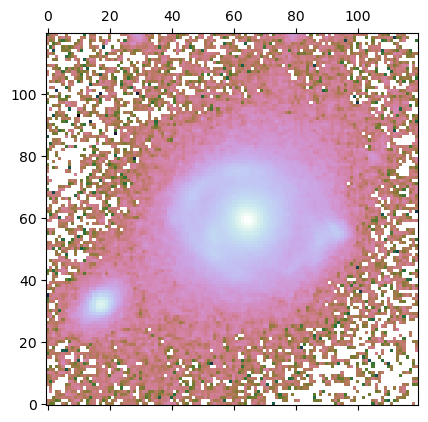

In [3]:
plt.matshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")

In [4]:
# To make a mask using lenstronomy functions, here is an example code:


ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r1 = 5  # arcsecond
r2 = 2.5
lens_center_ra = 0
lens_center_dec = 0

mask_outer_1 = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r1,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 3.5,
    lens_center_dec - 2.2,
    1,
    1,
    0,
)

mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.5,
    lens_center_dec + 1.7,
    0.5,
    0.5,
    0,
)


mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.7,
    lens_center_dec - 0.4,
    0.3,
    0.3,
    0,
)

mask = (1 - mask_outer_1) * (1 - mask_ext_1) * (1 - mask_ext_2)
mask[mask >= 1] = 1
mask[mask < 0] = 0


mask_img = mask.reshape(num_pix, num_pix)

## Applying mask

/tmp/ipykernel_6479/4187877492.py:3: RuntimeWarning: invalid value encountered in log10
  ori = np.log10(kwargs_data["image_data"])
/tmp/ipykernel_6479/4187877492.py:5: RuntimeWarning: divide by zero encountered in log10
  masked_img = np.log10(kwargs_data["image_data"] * mask_img)
/tmp/ipykernel_6479/4187877492.py:5: RuntimeWarning: invalid value encountered in log10
  masked_img = np.log10(kwargs_data["image_data"] * mask_img)
/tmp/ipykernel_6479/4187877492.py:8: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")


Text(0.5, 1.0, 'Masked image')

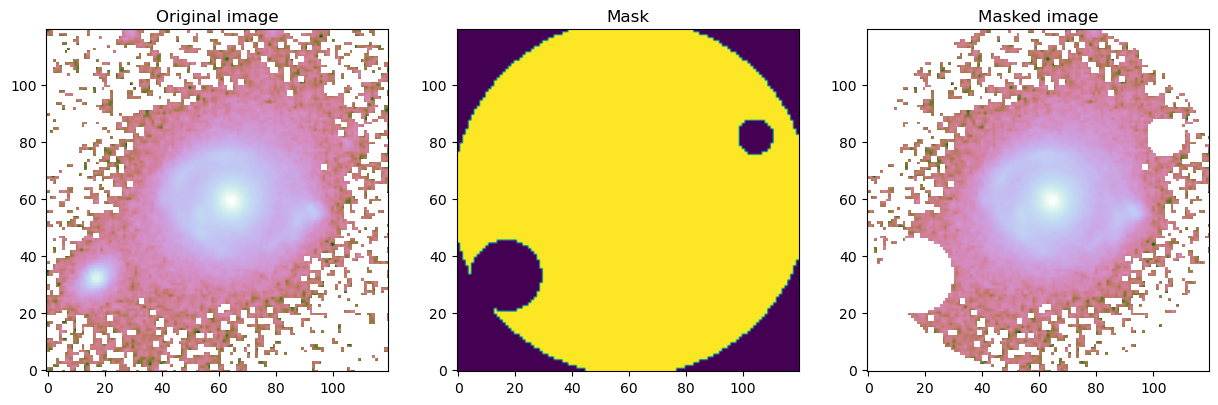

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))

ori = np.log10(kwargs_data["image_data"])

masked_img = np.log10(kwargs_data["image_data"] * mask_img)

plt.sca(axs[0])
plt.imshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")
plt.title("Original image")

plt.sca(axs[1])
plt.imshow(mask_img, origin="lower")
plt.title("Mask")

plt.sca(axs[2])
plt.imshow(masked_img, origin="lower", cmap="cubehelix")
plt.title("Masked image")

In [6]:
print("Mask dimension:", mask_img.shape, "\nMask type: ", type(mask_img))

Mask dimension: (120, 120) 
Mask type:  <class 'numpy.ndarray'>


## Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. You can check [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{q x^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

In [7]:
lens_model_list = ["EPL", "SHEAR"]


# beta, n_max, center_x, center_y
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]


lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

In this cell below, we have to specify the initial values, upper and lower
limits for the model parameters specific to each of the model components
specified in the above lists. The `kwargs_*_sigma` dictionaries/lists are
used to set the initial size of the search area within particle swarm
optimization (PSO) or MCMC.

In [8]:
# lens galaxy's mass model
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []


# 'EPL'
fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 1,
        "gamma": 1.57173,
        "e1": -0.0273,
        "e2": -0.04065,
        "center_x": -0.32511,
        "center_y": -0.09292,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 0.01,
        "gamma": 1,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)

# 'SHEAR'
fixed_lens.append({"ra_0": 0, "dec_0": 0})
kwargs_lens_init.append({"gamma1": 0.04321, "gamma2": -0.03227})
kwargs_lens_sigma.append({"gamma1": 0.01, "gamma2": 0.01})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3})


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]


# 1st Sersic profile. lens galaxy's light model
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []


fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        "R_sersic": 0.4761,
        "n_sersic": 4.0,
        "e1": 0.2178,
        "e2": -0.0474,
        "center_x": 0.0295,
        "center_y": -0.2483,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


# 2nd Sersic profile. lens galaxy's light model
fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        "R_sersic": 0.4761,
        "n_sersic": 4.0,
        "e1": 0.2178,
        "e2": -0.0474,
        "center_x": 0.0295,
        "center_y": -0.2483,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]


# source galaxy's light model
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


# for 'SERSIC_ELLIPSE'
fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.1,
        "n_sersic": 1.0,
        "e1": -0.4998,
        "e2": -0.22137,
        "center_x": -0.27066,
        "center_y": -0.1640,
        "amp": 1,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.01,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.01,
        "center_y": 0.01,
        "amp": 1,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.7,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 0.2,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)
# for ‘SHAPELETS’
fixed_source.append({"n_max": 5})
kwargs_source_init.append(
    {"beta": 0.05, "n_max": 5, "center_x": -0.27066, "center_y": 0.07217}
)
kwargs_source_sigma.append({"beta": 0.01, "center_x": 0.01, "center_y": 0.01})
kwargs_lower_source.append({"beta": 0, "center_x": -10, "center_y": -10})
kwargs_upper_source.append({"beta": 0.15, "center_x": 10, "center_y": 10})


joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]


source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]


# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_source_with_source": joint_source_with_source,
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
}

#### Numerical settings

No need to change anything here for now. It's also fine to not
understand these settings for now.

In [9]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask_img]}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

#### Combining all the information to be sent to lenstronomy

In [11]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band"
    # 'multi-linear': every imaging band has-
    # independent solutions of the surface brightness,
    # 'joint-linear': there is one joint solution of-
    # the linear coefficients demanded across the bands.
}

## Here the model fiting is done
Fixed 'gamma' inside fitting_kwargs_list: [lenstronomy.Workflow.fitting_sequence.FittingSequence.update_settings](https://lenstronomy.readthedocs.io/en/stable/lenstronomy.Workflow.html?highlight=update_settings#lenstronomy.Workflow.fitting_sequence.FittingSequence.update_settings)

In [11]:
start_time = time.time()

fitting_kwargs_list = [
    ["update_settings", {"lens_add_fixed": [[0, ["gamma"], [2]]]}],
    ["PSO", {"sigma_scale": 1.0, "n_particles": 100, "n_iterations": 100}],
    ["update_settings", {"lens_remove_fixed": [[0, ["gamma"]]]}],
    # ['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers':
    # 200, 'sigma_scale': .1}]
]


fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    mpi=False,
    verbose=True,
)

fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)

end_time = time.time()
print(end_time - start_time, "total time needed for computation")

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.0139234053447796 reduced X^2 of best position
-5771.252023222485 log likelihood
11384 effective number of data points
[{'theta_E': 1.5134806744872102, 'gamma': 2, 'e1': -0.11834539341381085, 'e2': -0.13422922960180692, 'center_x': -0.29381568159220073, 'center_y': -0.11619229847620677}, {'gamma1': 0.09087271488251004, 'gamma2': 0.03423982816002946, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.0931537084894418, 'n_sersic': 1.0, 'e1': -0.3949480965839539, 'e2': 0.2318799537133239, 'center_x': -0.5464697205694885, 'center_y': -0.14936722145348824}, {'amp': 1, 'n_max': 5, 'beta': 0.14993036411750452, 'center_x': -0.5464697205694885, 'center_y': -0.14936722145348824}] source result
[{'amp': 1, 'R_sersic': 0.9578468959465047, 'n_sersic': 4.0, 'e1': 0.32110329105519186, 'e2': 0.08042152997055634, 'center_x': -0.3307501106339642, 'center_y': -0.09821869138168597}, {'amp': 1, 'R_sersic': 0.

In [12]:
#### save model ####

kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed()

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]
output = [kwargs_result, multi_band_list_out, fit_output, kwargs_fixed_out]

output_path = "./DESIJ1554+0443_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)
print("Result saved in: %s" % output_path)

NameError: name 'fitting_seq' is not defined

In [15]:
### load model ###

load_output_path = "./DESIJ1554+0443_pso_output.joblib"
with open(load_output_path, "rb") as f:
    [input_, output_] = joblib.load(f)

(
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
) = input_

kwargs_result, multi_band_list_out, fit_output, _ = output_

## Visualizing the fitted model

{'kwargs_lens': [{'theta_E': 1.5134806744872102, 'gamma': 2, 'e1': -0.11834539341381085, 'e2': -0.13422922960180692, 'center_x': -0.29381568159220073, 'center_y': -0.11619229847620677}, {'gamma1': 0.09087271488251004, 'gamma2': 0.03423982816002946, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.0931537084894418, 'n_sersic': 1.0, 'e1': -0.3949480965839539, 'e2': 0.2318799537133239, 'center_x': -0.5464697205694885, 'center_y': -0.14936722145348824}, {'amp': 1, 'n_max': 5, 'beta': 0.14993036411750452, 'center_x': -0.5464697205694885, 'center_y': -0.14936722145348824}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 0.9578468959465047, 'n_sersic': 4.0, 'e1': 0.32110329105519186, 'e2': 0.08042152997055634, 'center_x': -0.3307501106339642, 'center_y': -0.09821869138168597}, {'amp': 1, 'R_sersic': 0.9089343502449374, 'n_sersic': 4.0, 'e1': 0.04316830038518695, 'e2': -0.0398453123366313, 'center_x': -0.3307501106339642, 'center_y': -0.09821869138168597}], 'kwargs_ps': [], 'k

/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
/tmp/ipykernel_6479/193619846.py:25: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


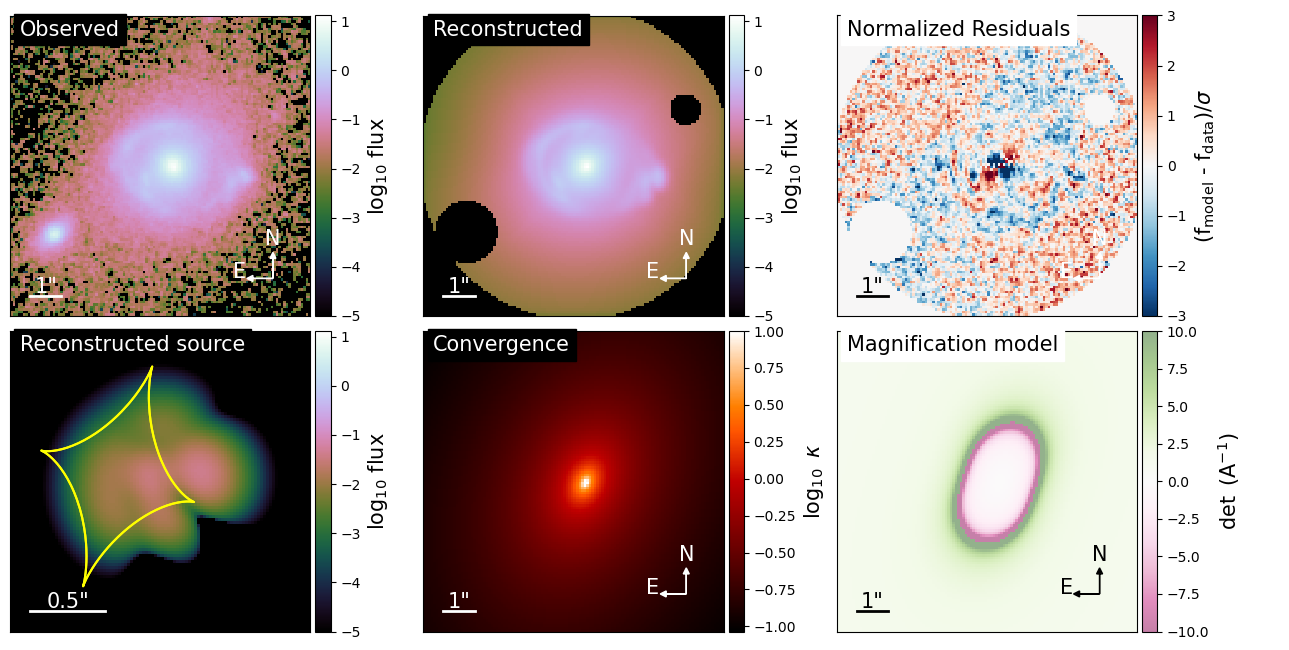

/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:506: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


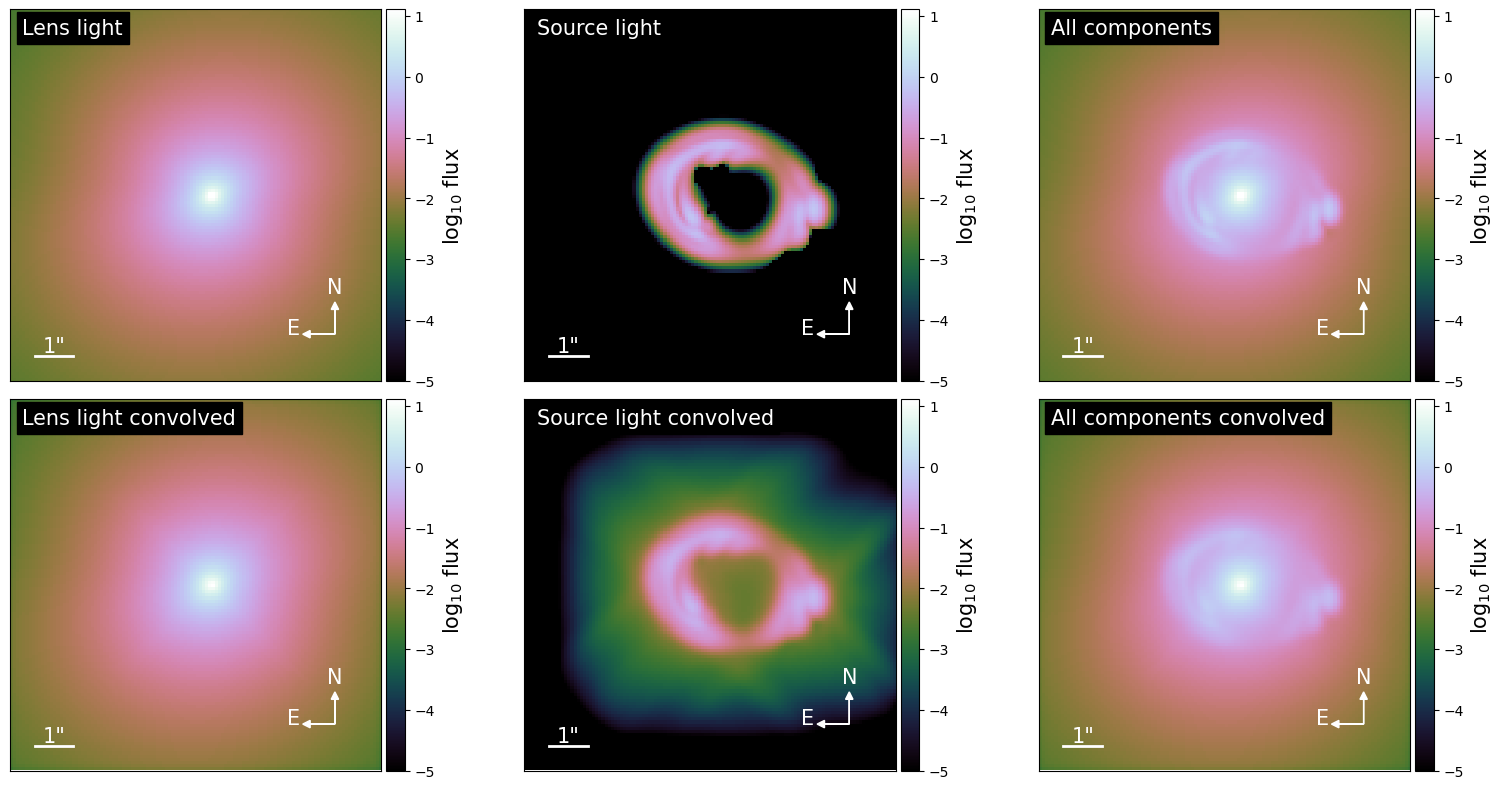

In [16]:
print(kwargs_result)
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0],
    deltaPix_source=0.02,
    numPix=100,
    scale_size=0.5,
    with_caustics=True,
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

def mcmc(self, n_burn, n_run, walkerRatio=None, n_walkers=None, sigma_scale=1, threadCount=1, init_samples=None,
             re_use_samples=True, sampler_type='EMCEE', progress=True, backend_filename=None, start_from_backend=False,
             **kwargs_zeus):
        """
        MCMC routine

        :param n_burn: number of burn in iterations (will not be saved)
        :param n_run: number of MCMC iterations that are saved
        :param walkerRatio: ratio of walkers/number of free parameters
        :param n_walkers: integer, number of walkers of emcee (optional, if set, overwrites the walkerRatio input
        :param sigma_scale: scaling of the initial parameter spread relative to the width in the initial settings
        :param threadCount: number of CPU threads. If MPI option is set, threadCount=1
        :param init_samples: initial sample from where to start the MCMC process
        :param re_use_samples: bool, if True, re-uses the samples described in init_samples.nOtherwise starts from
         scratch.
        :param sampler_type: string, which MCMC sampler to be used. Options are: 'EMCEE', 'ZEUS'
        :param progress: boolean, if True shows progress bar in EMCEE
        :param backend_filename: name of the HDF5 file where sampling state is saved (through emcee backend engine)
        :type backend_filename: string
        :param start_from_backend: if True, start from the state saved in `backup_filename`.
         O therwise, create a new backup file with name `backup_filename` (any already existing file is overwritten!).
        :type start_from_backend: bool
        :param kwargs_zeus: zeus-specific kwargs
        :return: list of output arguments, e.g. MCMC samples, parameter names, logL distances of all samples specified
         by the specific sampler used
        """






from: zareef_Intro to lens modeling with lenstronomy.ipynb

from lenstronomy.Workflow.fitting_sequence import FittingSequence


fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 500, "n_iterations": 100}],
    ["MCMC", {"n_burn": 200, "n_run": 600, "n_walkers": 200, "sigma_scale": 0.1}],
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

## MCMC

In [17]:
# from lenstronomy.Workflow.fitting_sequence import FittingSequence


# fitting_seq = FittingSequence(
#     kwargs_data_joint,
#     kwargs_model,
#     kwargs_constraints,
#     kwargs_likelihood,
#     kwargs_params,
# )

# fitting_kwargs_list_mcmc = [
#     ["MCMC", {"n_burn": 0, "n_run": 20, "n_walkers": 1000, 
#     "sigma_scale": 0.1, #"threadCount": 10,
#     "backend_filename": "backend_mcmc.h5", "start_from_backend":0
#     }],
# ]

# chain_list = fitting_seq.fit_sequence(fitting_kwargs_list_mcmc)
# kwargs_result = fitting_seq.best_fit()









mcmc_backend = "mcmc_backend.h5"

n_walkers = 200 #200, 60
n_step = 500 #1000,100,1000, 1500, 500
n_burn = 3000
init_samples = 500000 #0, 220000, 260000, 460000, 1000000

fitting_kwargs_list_mcmc = [
    [
        "MCMC",
        {
            "n_burn": n_burn,
            "n_run": n_step,
            "n_walkers": n_walkers,
            "sigma_scale": 0.1,
            "backend_filename": mcmc_backend,
            "start_from_backend": True,
        },
    ]
]

fitting_seq_mcmc = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

chain_list_mcmc = fitting_seq_mcmc.fit_sequence(fitting_kwargs_list_mcmc)


100%|██████████| 500/500 [29:24<00:00,  3.53s/it]

Computing the MCMC...
Number of walkers =  200
Burn-in iterations:  3000
Sampling iterations (in current run): 500
1764.913803100586 time taken for MCMC sampling


In [19]:
kwargs_result_mcmc = fitting_seq_mcmc.best_fit()
print(kwargs_result_mcmc)

{'kwargs_lens': [{'theta_E': 1.5067581095825522, 'gamma': 1.8904822603698728, 'e1': -0.040309866222832426, 'e2': -0.10184439037838816, 'center_x': -0.29242504129128527, 'center_y': -0.11159130670709981}, {'gamma1': 0.10688744929291215, 'gamma2': 0.03494391561157853, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.19919983612656295, 'n_sersic': 1.0, 'e1': -0.3879207176869724, 'e2': -0.35214145198407454, 'center_x': -0.4708827438889511, 'center_y': -0.09094553718817973}, {'amp': 1, 'n_max': 5, 'beta': 0.14540223843539649, 'center_x': -0.4708827438889511, 'center_y': -0.09094553718817973}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 0.49618063160543213, 'n_sersic': 4.0, 'e1': -0.06686542716305341, 'e2': -0.2328462184368, 'center_x': -0.3302467993257423, 'center_y': -0.09515750590790524}, {'amp': 1, 'R_sersic': 0.5284770963906795, 'n_sersic': 4.0, 'e1': -0.06069009745934361, 'e2': -0.2116975025728977, 'center_x': -0.3302467993257423, 'center_y': -0.09515750590790524}]

In [153]:
# reader = emcee.backends.HDFBackend("mcmc_backend.h5", read_only=True)
# flatchain = reader.get_chain(flat=True)

In [18]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != "PSO":
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        if samples_mcmc == []:
            samples_mcmc = chain_list_mcmc[k][1]
        else:
            samples_mcmc = np.vstack((samples_mcmc, chain_list_mcmc[k][1]))

        param_mcmc = chain_list_mcmc[k][2]

print(samples_mcmc.shape)

(600000, 22)


/tmp/ipykernel_6479/2449223460.py:26: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


N_step: 3000, N_walkers: 200, N_params: 22
theta_E_lens0 1.5052 ± 0.0042
gamma_lens0 1.8958 ± 0.0182
e1_lens0 -0.0426 ± 0.0089
e2_lens0 -0.1040 ± 0.0098
center_x_lens0 -0.2899 ± 0.0051
center_y_lens0 -0.1121 ± 0.0053
gamma1_lens1 0.1062 ± 0.0053
gamma2_lens1 0.0353 ± 0.0062
R_sersic_source_light0 0.1992 ± 0.0013
e1_source_light0 -0.4063 ± 0.0351
e2_source_light0 -0.3611 ± 0.0325
center_x_source_light0 -0.4698 ± 0.0062
center_y_source_light0 -0.0933 ± 0.0069
beta_source_light1 0.1466 ± 0.0030
R_sersic_lens_light0 0.4742 ± 0.0230
e1_lens_light0 -0.0695 ± 0.0090
e2_lens_light0 -0.2523 ± 0.0160
center_x_lens_light0 -0.3303 ± 0.0008
center_y_lens_light0 -0.0951 ± 0.0007
R_sersic_lens_light1 0.5542 ± 0.0206
e1_lens_light1 -0.0551 ± 0.0057
e2_lens_light1 -0.1962 ± 0.0130


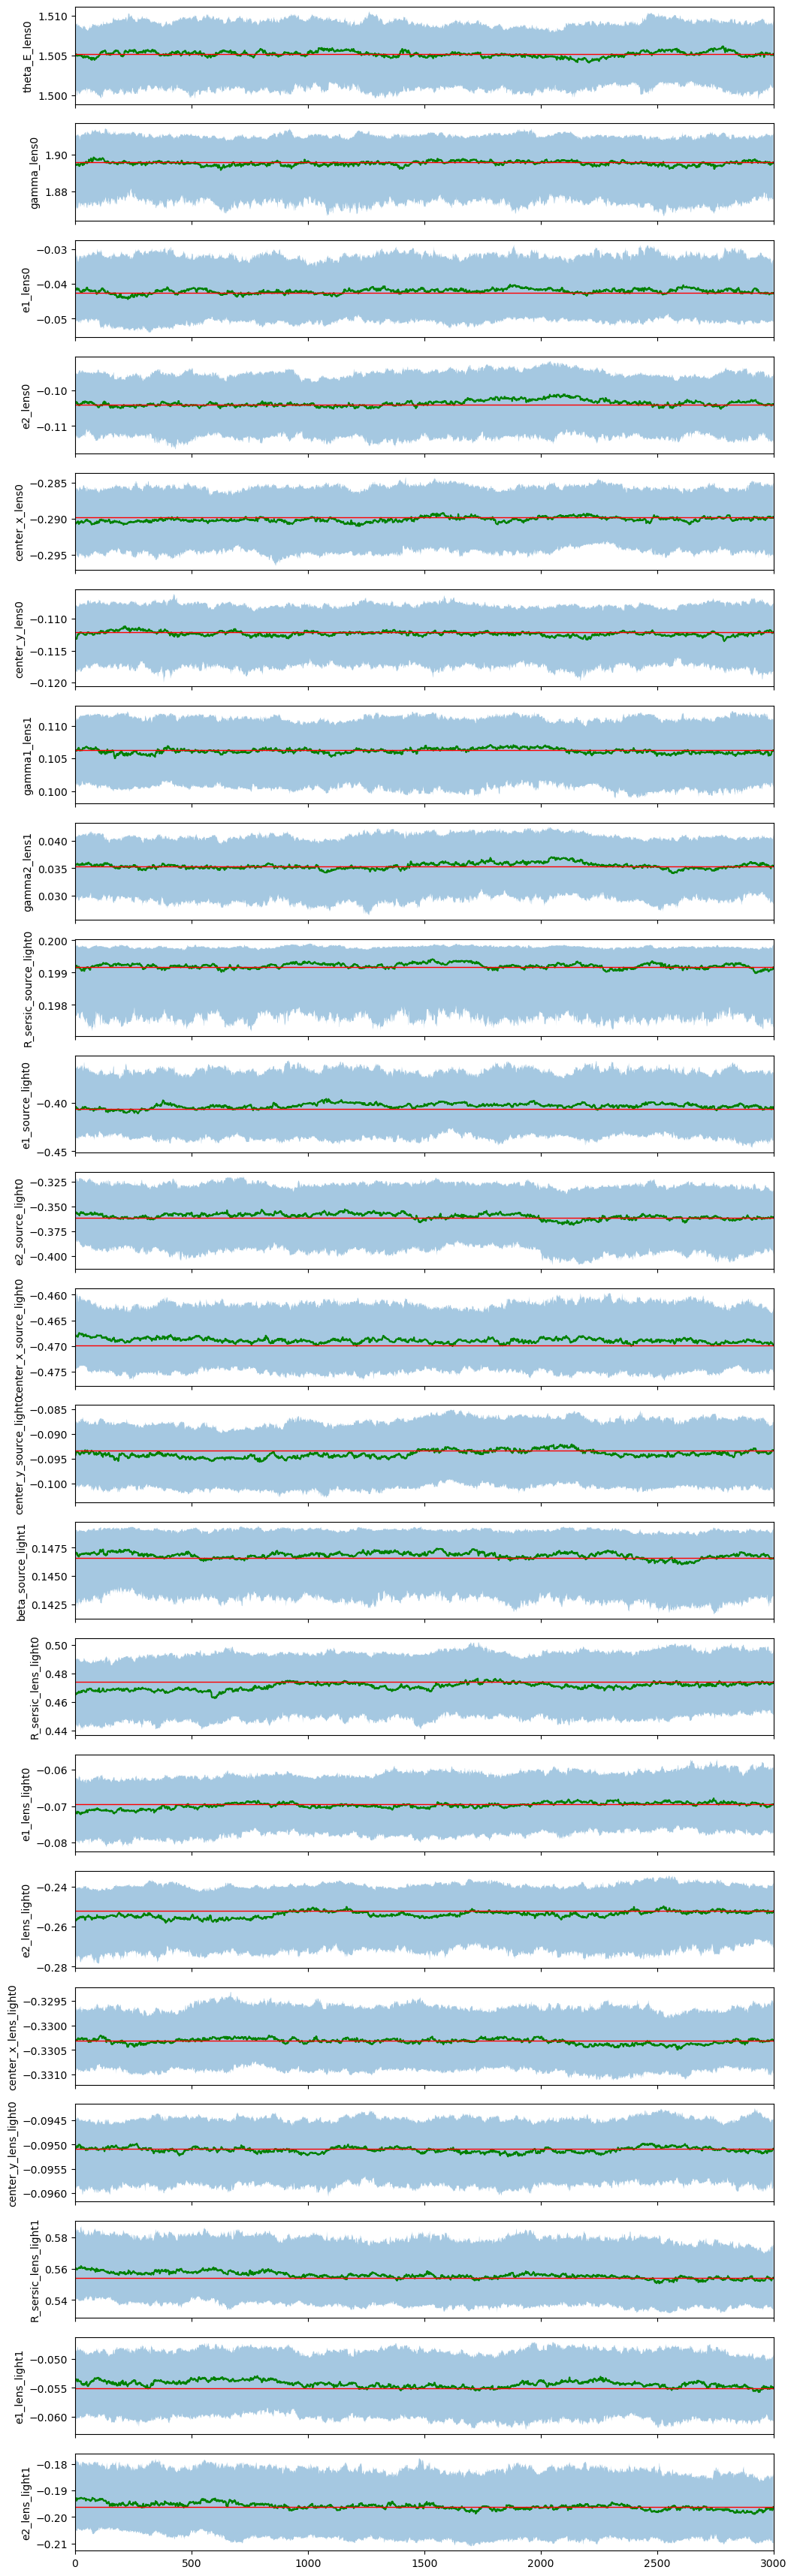

In [24]:
# if len(chain_list) > 0:
#     for i, chain in enumerate(chain_list):
#         print(f"Chain {i + 1}:")
#         print("Sampler type:", chain[0])
#         print("Parameter names:", chain[2])
#         print("Shape of samples:", chain[1].shape)
#         print("")

#     # Alternatively, you can access the last chain directly
#     last_chain = chain_list[-1]
#     last_samples = last_chain[1]
#     last_param_names = last_chain[2]
#     print("Last Chain:")
#     print("Sampler type:", last_chain[0])
#     print("Parameter names:", last_param_names)
#     print("Shape of samples:", last_samples.shape)
# else:
#     print("No MCMC chains available.")







if not samples_mcmc == []:

    # n_params = samples_mcmc.shape[1]

    # n_walkers = walker_ratio * n_params
    # n_step = int(samples_mcmc.shape[0] / n_walkers)



    n_params = samples_mcmc.shape[1]
    n_walkers = 200 #1000
    n_step = int(samples_mcmc.shape[0] / n_walkers) #100
    n_burn = 0

    print("N_step: {}, N_walkers: {}, N_params: {}".format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order="F")
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.0)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.0)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [
        median_pos[0][last - 1],
        (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
        median_pos[1][last - 1],
        (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2,
    ]

    for i in range(n_params):
        print(
            param_mcmc[i],
            "{:.4f} ± {:.4f}".format(
                median_pos[i][last - 1],
                (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2,
            ),
        )

        ax[i].plot(median_pos[i][:last], c="g")
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c="r", lw=1)
        ax[i].fill_between(
            np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4
        )

        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12.0, 2 * len(param_mcmc)))
        plt.show()

Number of non-linear parameters in the MCMC process: 22
Parameters in order: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'e1_lens_light1', 'e2_lens_light1']
Number of evaluations in the MCMC process: 600000
600000
Shape of samples_mcmc_cut: (29800, 22)


/tmp/ipykernel_6479/415149424.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc_cut == []:


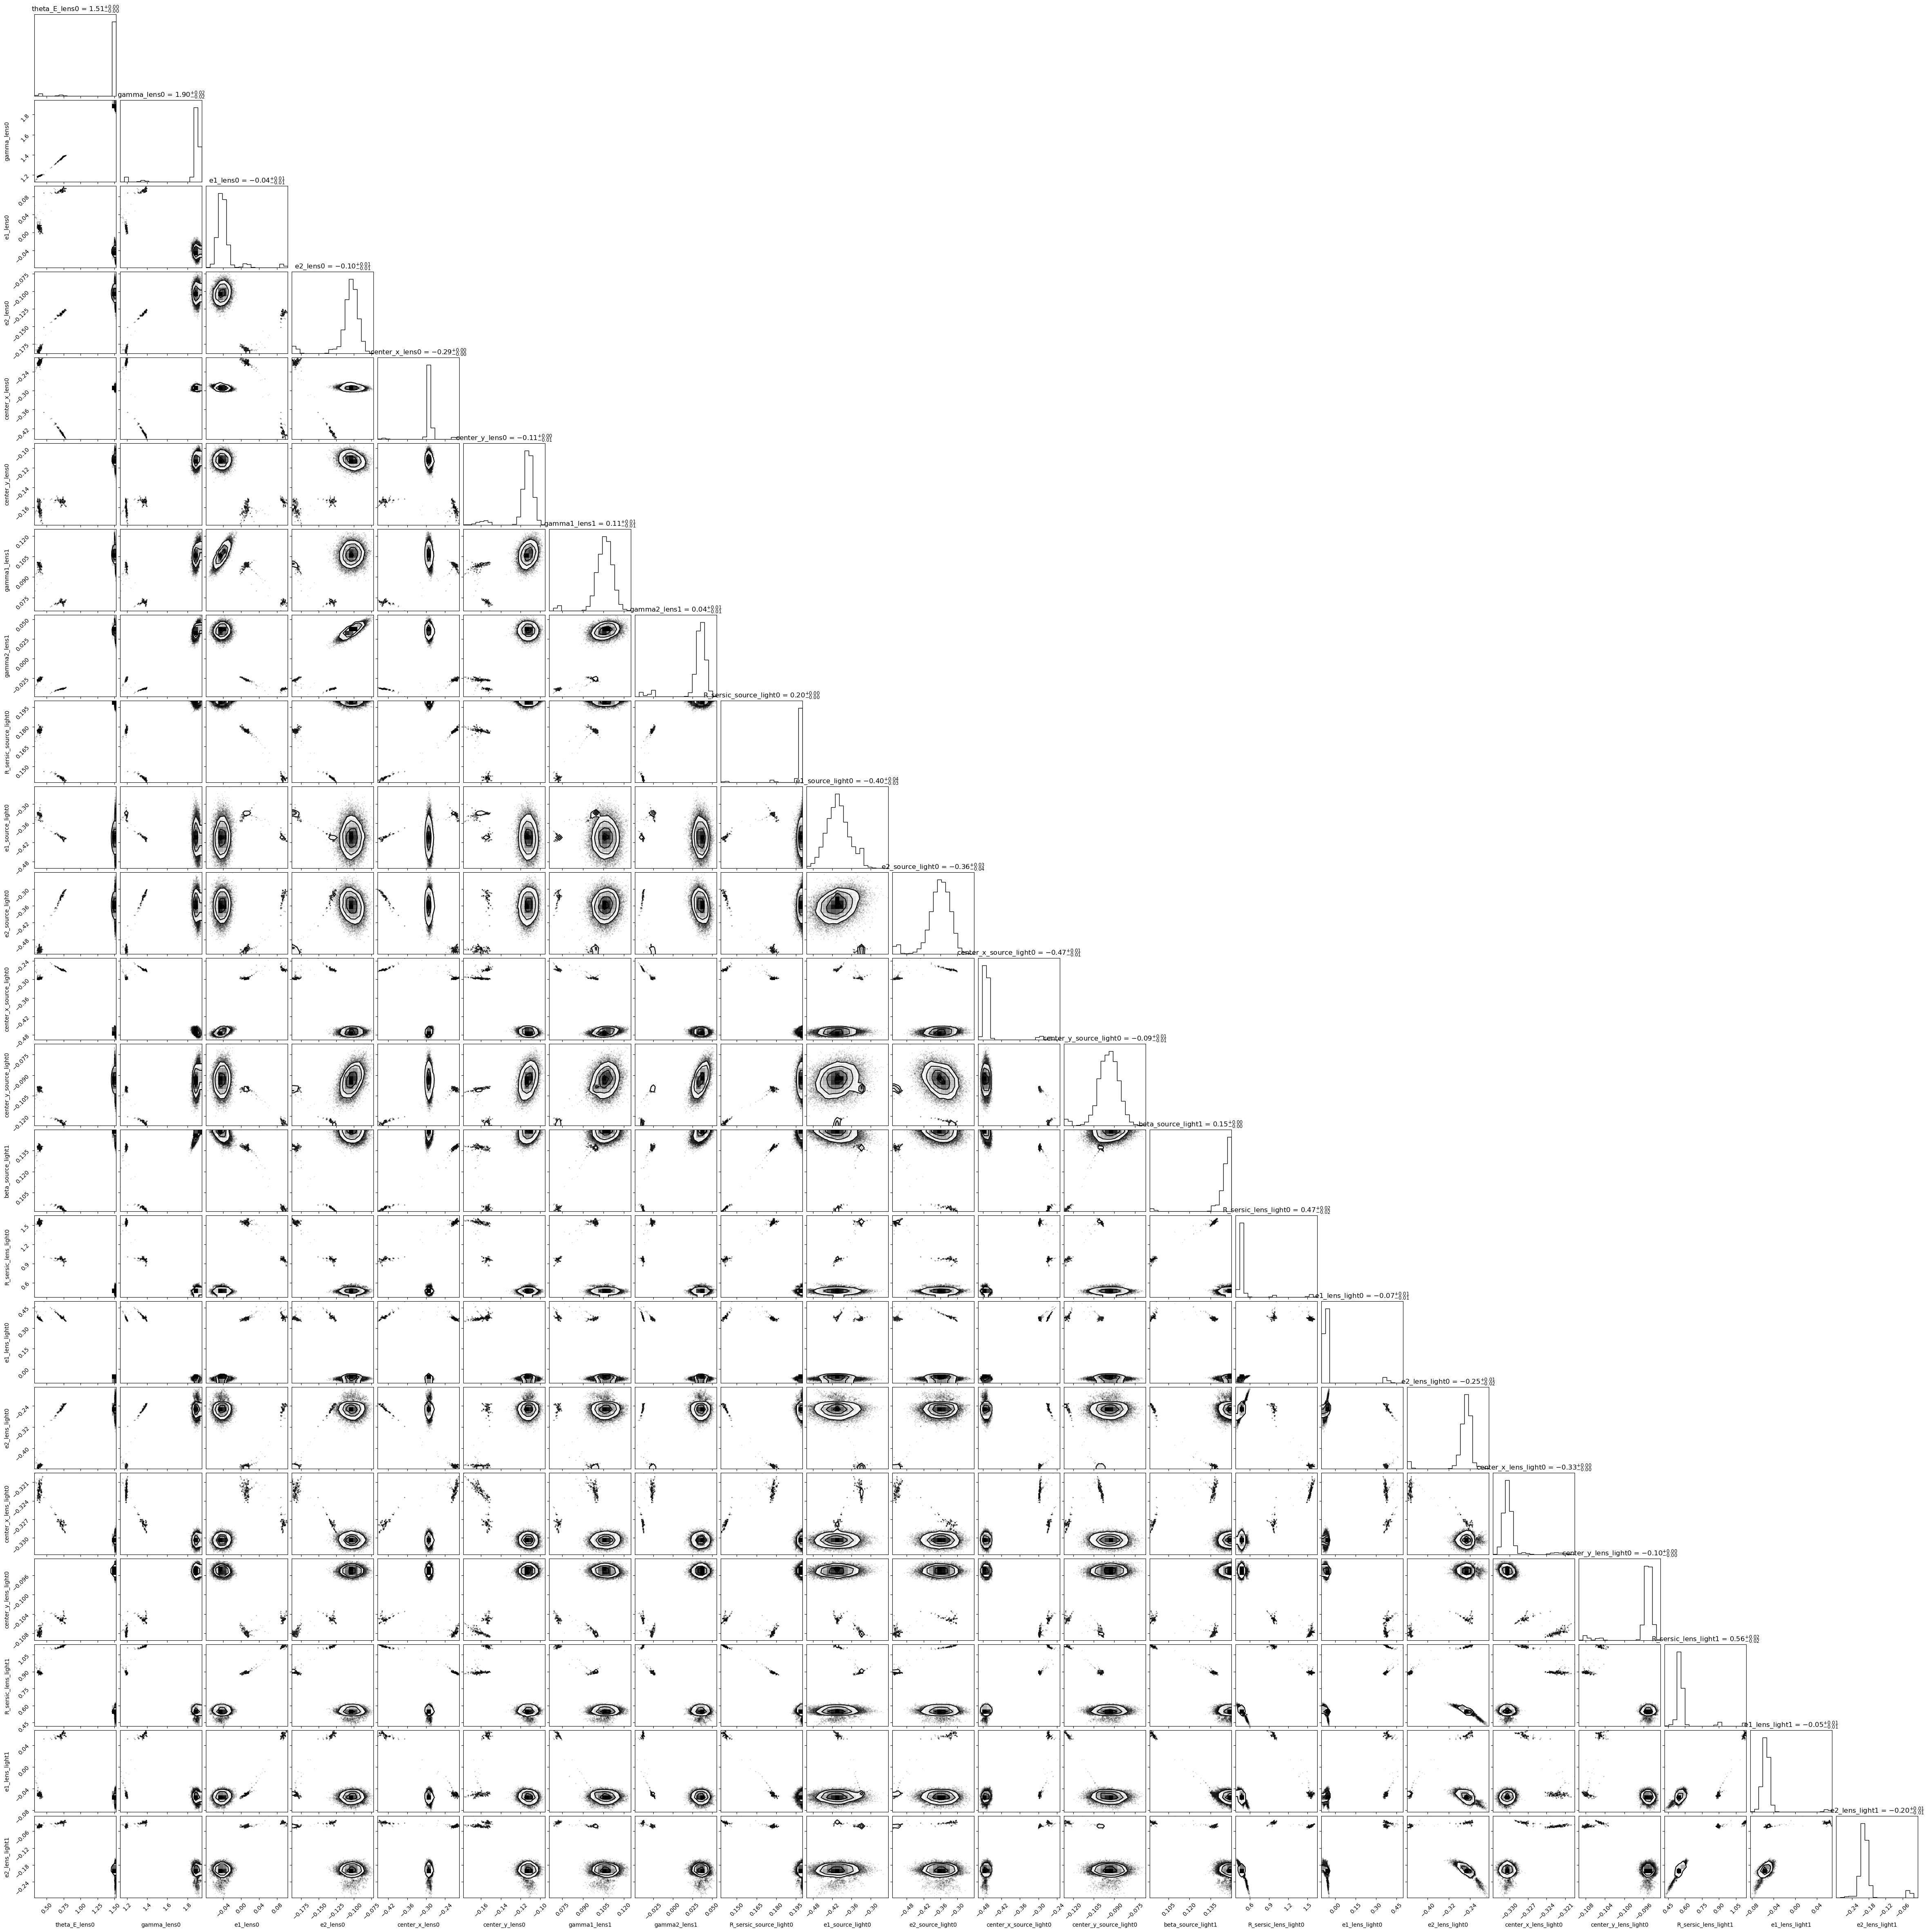

In [25]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq_mcmc.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 30
        thin = 20
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")


-0.8778594425853953 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8778594425852243


/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
/tmp/ipykernel_6479/379796333.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


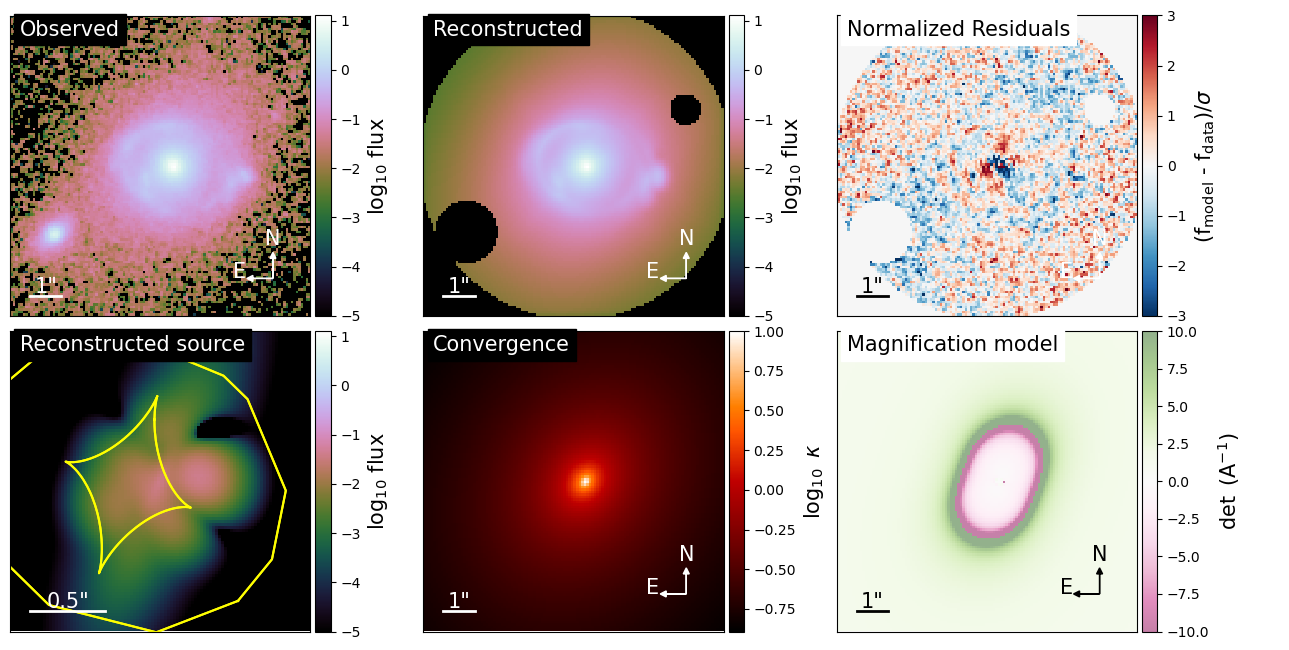

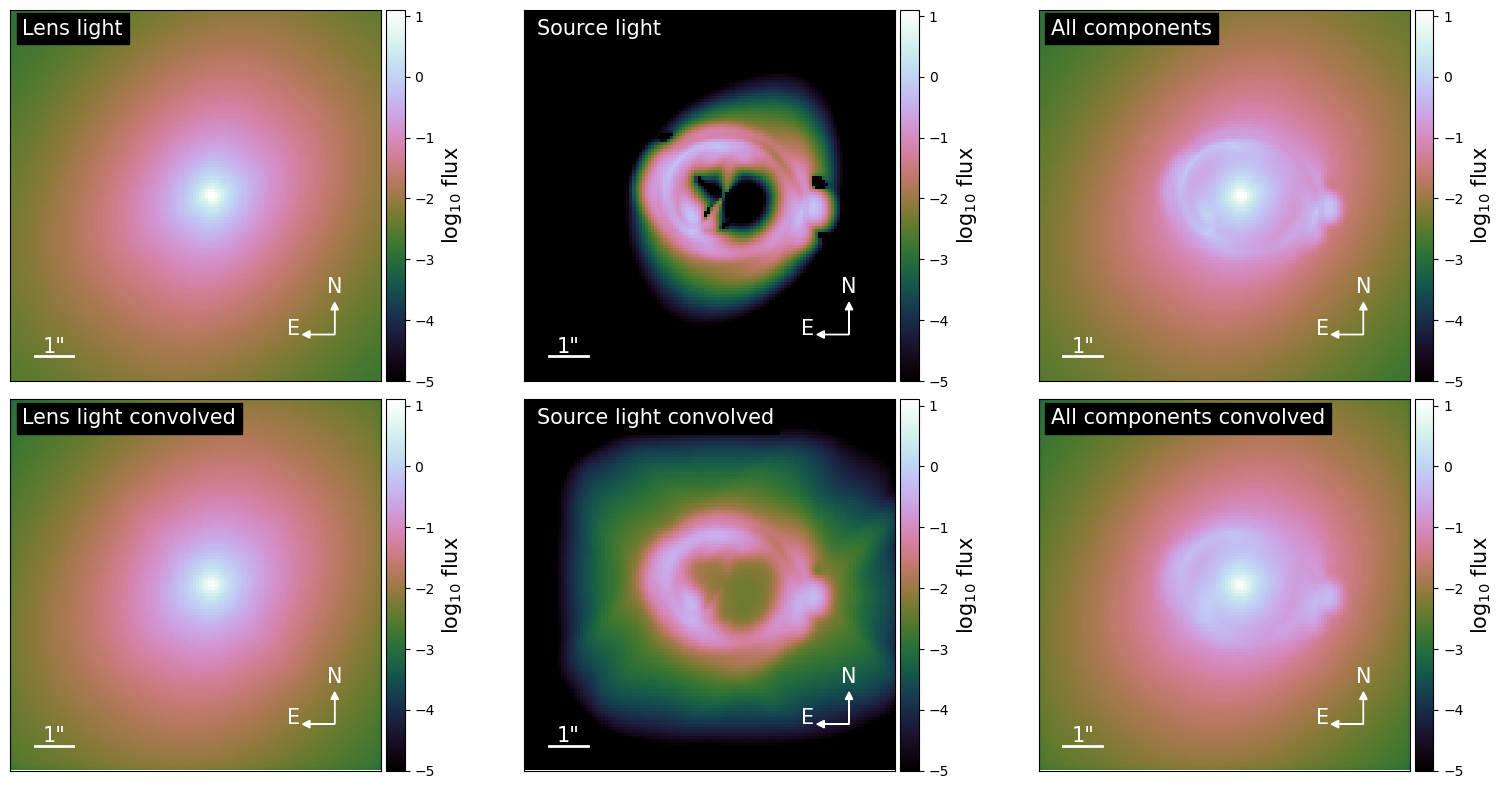

{'kwargs_lens': [{'theta_E': 1.5067581095825522, 'gamma': 1.8904822603698728, 'e1': -0.040309866222832426, 'e2': -0.10184439037838816, 'center_x': -0.29242504129128527, 'center_y': -0.11159130670709981}, {'gamma1': 0.10688744929291215, 'gamma2': 0.03494391561157853, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.19919983612656295, 'n_sersic': 1.0, 'e1': -0.3879207176869724, 'e2': -0.35214145198407454, 'center_x': -0.4708827438889511, 'center_y': -0.09094553718817973}, {'amp': 1, 'n_max': 5, 'beta': 0.14540223843539649, 'center_x': -0.4708827438889511, 'center_y': -0.09094553718817973}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 0.49618063160543213, 'n_sersic': 4.0, 'e1': -0.06686542716305341, 'e2': -0.2328462184368, 'center_x': -0.3302467993257423, 'center_y': -0.09515750590790524}, {'amp': 1, 'R_sersic': 0.5284770963906795, 'n_sersic': 4.0, 'e1': -0.06069009745934361, 'e2': -0.2116975025728977, 'center_x': -0.3302467993257423, 'center_y': -0.09515750590790524}]

In [22]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
    linear_solver=kwargs_constraints.get("linear_solver", True),
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.02, numPix=100, with_caustics=True, scale_size=0.5
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result_mcmc)

{'kwargs_lens': [{'theta_E': 1.4990488627794596, 'gamma': 1.8633139678575283, 'e1': -0.01328152314943569, 'e2': -0.04703599203374558, 'center_x': -0.28327315142524434, 'center_y': -0.12809022827765934}, {'gamma1': 0.11419153427727448, 'gamma2': 0.05974866120505368, 'ra_0': 0, 'dec_0': 0}], 

'kwargs_source': [{'amp': 1, 'R_sersic': 0.046780783877554744, 'n_sersic': 1.0, 'e1': -0.23551118959369352, 'e2': -0.39654280753088533, 'center_x': -0.4176415475917611, 'center_y': -0.08480597311088899}, {'amp': 1, 'n_max': 5, 'beta': 0.13824668151035735, 'center_x': -0.4176415475917611, 'center_y': -0.08480597311088899}],

'kwargs_lens_light': [{'amp': 1, 'R_sersic': 2.1347413855875574, 'n_sersic': 4.0, 'e1': 0.07357309072254042, 'e2': 0.16709709486349283, 'center_x': -0.3306504436220997, 'center_y': -0.0985848554230107}, {'amp': 1, 'R_sersic': 1.2636516450568258, 'n_sersic': 4.0, 'e1': 0.019229576808728187, 'e2': 0.03696227729607814, 'center_x': -0.3306504436220997, 'center_y': -0.0985848554230107}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}
